In [10]:
import sys
local_path = "/home/brandon/Omdena/Omdena HeartKinetics/HeartKinetics - Project/signals.feather"
sys.path.append(local_path)

In [11]:
from pathlib import Path
data_path = Path(local_path) / "data"

In [12]:
cd $local_path

[Errno 20] Not a directory: '/home/brandon/Omdena/Omdena HeartKinetics/HeartKinetics - Project/signals.feather'
/home/brandon/Omdena/Omdena HeartKinetics/HeartKinetics - Project


In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Saving data to feather

In [14]:
raw_data_path = Path("/home/brandon/Omdena/Omdena HeartKinetics/HeartKinetics - Project/signals.feather")

In [16]:
import RecordReader, find_records
records = find_records(raw_data_path)

ModuleNotFoundError: No module named 'RecordReader'

In [ ]:
import pandas as pd
import warnings
from tqdm import tqdm

subjects_data = []
records_data = []
signals_df = pd.DataFrame()

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='.* highly fragmented.*')
    
    # Setting new sampling frequency
    new_fs = 200
    
    # Iterating over records:
    for record in tqdm(records, desc="Processing", bar_format="{l_bar}{bar:20}{r_bar}"):
        
        reader = RecordReader(record)
        crf_meta = reader.load_crf_metadata()
        subject_meta = reader.load_subject_metadata()
        
        subjects_data.append({
            "study_id": crf_meta["study_id"],
            "subject_id": crf_meta["subject_id"],
            "sex": subject_meta['subject']['sex'],
            "hf_type":crf_meta["hf_type"],
        })
        
        records_data.append({
            "record_id": subject_meta['id'],
            "study_id": crf_meta["study_id"],
            "subject_id": crf_meta["subject_id"],
            "height": subject_meta['subject']['height']['value'],
            "weight": subject_meta['subject']['weight']['value'],
            "age": subject_meta['subject']['age']['value'],
        })
               
        # Reading Singals
        df = pd.DataFrame({
            "nrg_lin": reader.load_signal("scg-k").nrg.sel(motion="lin").to_pandas(),
            "nrg_rot": reader.load_signal("scg-k").nrg.sel(motion="rot").to_pandas(),
            "pwr_lin": reader.load_signal("scg-k").pwr.sel(motion="lin").to_pandas(),
            "pwr_rot": reader.load_signal("scg-k").pwr.sel(motion="rot").to_pandas(),
            "rsp": reader.load_signal("rsp").signal.to_pandas()
        })#.astype('float32')

        fs = reader.load_scg_metadata()['sample_rate']

        # Indexing time series
        dt = 1/fs
        time_index = pd.timedelta_range(0, periods=df.shape[0], freq=f"{dt*1e3}ms")
        df.index = time_index

        # Resampling
        df = (
            df
            .resample(f'{(1/new_fs)*1e3}ms').mean()
            .interpolate()
        )
        
        id_ = subject_meta['id']
        
        signals_df[(id_, "nrg_lin")] = df["nrg_lin"]
        signals_df[(id_, "nrg_rot")] = df["nrg_rot"]
        signals_df[(id_, "pwr_lin")] = df["pwr_lin"]
        signals_df[(id_, "pwr_rot")] = df["pwr_rot"]
        signals_df[(id_, "rsp")] = df["rsp"]
        

NameError: name 'records' is not defined

In [ ]:
subjects_df = (
    pd.DataFrame(subjects_data)
    .groupby(["study_id", "subject_id"])
    .agg({
        "sex": pd.Series.mode,
        "hf_type": pd.Series.mode,
    })
    .reset_index()
)

records_df = pd.DataFrame(records_data)

from datetime import timedelta
signals_df.columns = pd.MultiIndex.from_tuples(signals_df.columns)
signals_df = signals_df[:timedelta(seconds=60)]
signals_df = signals_df.T

<AxesSubplot: xlabel='study_id,subject_id'>

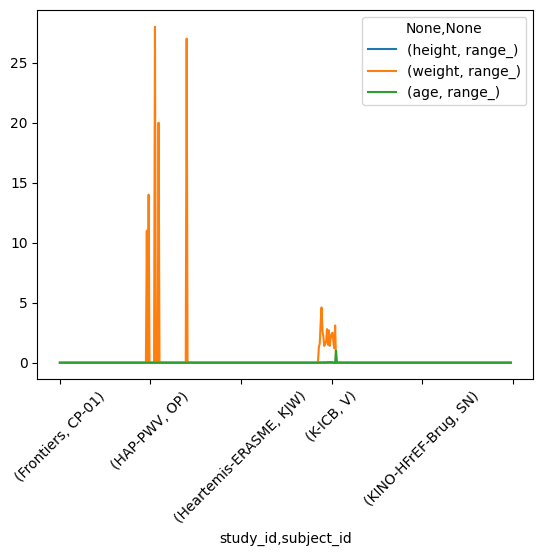

In [ ]:
def range_(x):
    return x.max()-x.min()
records_df.groupby(["study_id", "subject_id"])[["height", "weight", "age"]].agg([range_]).plot(rot=45)

In [ ]:
print(f"subjects_df memory usage {subjects_df.memory_usage().sum()/(2**10):.2f} kb")
print(f"records_df memory usage {records_df.memory_usage().sum()/(2**10):.2f} kb")
print(f"signal_df memory usage {signals_df.memory_usage().sum()/(2**20):.2f} Mb")

subjects_df memory usage 15.72 kb
records_df memory usage 41.89 kb
signal_df memory usage 407.82 Mb


In [ ]:
subjects_df.to_feather(data_path / "subjects_v2.feather")
records_df.to_feather(data_path / "records_v2.feather")
signals_df.columns = signals_df.columns.astype('str')
signals_df.index.rename(['record_id', 'channel'], inplace=True)
signals_df.reset_index().to_feather(data_path / "signals_v2.feather")

In [ ]:
ls $data_path

records.feather     signals.feather     subjects_test.feather
records_v2.feather  signals_v2.feather  subjects_train.feather
scaleogram/         subjects.feather    subjects_v2.feather


# 2. Defining Data Manager

In [ ]:
def data_from_feather(data_path):
    data_path = Path(data_path)
    subjects_df_ = pd.read_feather(data_path / "subjects_v2.feather")

    records_df_ = pd.read_feather(data_path / "records_v2.feather")

    signals_df_ = pd.read_feather(data_path / "signals_v2.feather")
    signals_df_ = signals_df_.set_index(["record_id", "channel"])
    signals_df_.columns = pd.to_timedelta(signals_df_.columns)
    
    return subjects_df_, records_df_, signals_df_

In [ ]:
from sklearn.model_selection import train_test_split
from numpy.random import seed
from sklearn.model_selection import StratifiedKFold
import pandas as pd

class DataManagerV2():
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        self.subjects, self.records, self.signals = data_from_feather(data_path=data_path)
        seed(42)
        
    def subjects_train_test_split(self, test_size=0.2, save=False):
        """
        Splits subjects into train and test stratifying by hf_type.
        
        save:bool If True, saves the splits in subjects_train.feather and subjects_test.feather at the data_path.
        """
        subjects = self.subjects.query("hf_type!='UNKNOWN'").query("study_id!='Frontiers'")
        
        subjects_train, subjects_test = train_test_split(
            subjects,
            test_size=test_size,
            stratify=subjects['hf_type'], 
        )
        
        if save:
            subjects_train.reset_index(drop=True).to_feather(self.data_path / "subjects_train.feather")
            subjects_test.reset_index(drop=True).to_feather(self.data_path / "subjects_test.feather")
            
        return subjects_train, subjects_test
    
    
    def subjects_train_test_val_split(self, test_size=0.2, val_size=0.1):
        """
        Splits subjects into train and test stratifying by hf_type.
        
        save:bool If True, saves the splits in subjects_train.feather and subjects_test.feather at the data_path.
        """
        subjects = self.subjects.query("hf_type!='UNKNOWN'").query("study_id!='Frontiers'")
        
        subjects_train, subjects_no_train = train_test_split(
            subjects,
            test_size=test_size + val_size,
            stratify=subjects['hf_type'], 
        )
        
        subjects_val, subjects_test = train_test_split(
            subjects_no_train,
            test_size= test_size / (test_size + val_size),
            stratify=subjects_no_train['hf_type'], 
        )
            
        return subjects_train, subjects_test, subjects_val
    
    
    def get_set_from_subjects(self, subjects):
        records = (
            subjects[['study_id', 'subject_id']]
            .merge(
                self.records,
                how="left",
                on=['study_id', 'subject_id'],
                validate="one_to_many"
            )
        )
        signals = (
            records[["record_id"]]
            .merge(
                self.signals.reset_index(),
                how="left",
                on=["record_id"],
                validate="one_to_many"
            )
            .set_index(["record_id", "channel"])
        )
        
        data_set = {
            "subjects": subjects.reset_index(drop=True),
            "records": records.reset_index(drop=True),
            "signals": signals
        }
        return data_set
        
        
    def train_test_split(self, test_size=0.2):
        """
        Returns the train and test datasets as dictionaries with keys subjects, records and signals.
        Notice it depends on the subjects_train.feather and subjects_test.feather files in the data path 
        (they can be generated using subjects_train_test_split method in this class).
        """
        
        #subjects_train = pd.read_feather(self.data_path / "subjects_train.feather")
        #subjects_test = pd.read_feather(self.data_path / "subjects_test.feather")
        
        subjects_train, subjects_test = self.subjects_train_test_split(test_size=test_size)
        
        train_set = self.get_set_from_subjects(subjects_train)
        test_set = self.get_set_from_subjects(subjects_test)
                                       
        return train_set, test_set
    
    def train_test_val_split(self, test_size=0.2, val_size=0.1):
        """
        Returns the train and test datasets as dictionaries with keys subjects, records and signals.
        Notice it depends on the subjects_train.feather and subjects_test.feather files in the data path 
        (they can be generated using subjects_train_test_split method in this class).
        """
        
        #subjects_train = pd.read_feather(self.data_path / "subjects_train.feather")
        #subjects_test = pd.read_feather(self.data_path / "subjects_test.feather")
        
        subjects_train, subjects_test, subjects_val = self.subjects_train_test_val_split(test_size=test_size, val_size=val_size)
        
        train_set = self.get_set_from_subjects(subjects_train)
        test_set = self.get_set_from_subjects(subjects_test)
        val_set = self.get_set_from_subjects(subjects_val)
                                       
        return train_set, test_set, val_set
    
    def train_test_k_fold(self, n_splits=3):
        kfold = StratifiedKFold(n_splits, shuffle=True)
        splits = kfold.split(self.subjects, self.subjects['hf_type'])
        
        for split in splits:
            train_idx, test_idx = split
            subjects_train = self.subjects.loc[train_idx]
            subjects_test = self.subjects.loc[test_idx]
            train_set = self.get_set_from_subjects(subjects_train)
            test_set = self.get_set_from_subjects(subjects_test)
            yield train_set, test_set

# 3 Sequence Generator

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import periodogram

fs = 200

def get_signal_features(s):
    name = s.name
    channel = name[-1]
    signal_values = s.values.reshape(-1, 1)
    f, pxx_values = periodogram(signal_values.T, fs)
    
    quantiles = np.linspace(0, 1, 6)
    
    features = {
        ** {f"signal_q_{q:.2f}": q_v for q, q_v in zip(quantiles, np.quantile(signal_values, quantiles))},
        ** {f"periodogram_q_{q:.2f}": q_v for q, q_v in zip(quantiles, np.quantile(pxx_values, quantiles))},
        f"max_power_freq": f[np.argmax(pxx_values)],
        f"max_power": pxx_values[:, np.argmax(pxx_values)][0],
        #**tsfel.time_series_features_extractor(cfg_tmp, signal_values.ravel(), fs=fs, verbose=0, header_names=['']).to_dict('records')[0],
        #**tsfel.time_series_features_extractor(cfg_stats, signal_values.ravel(), fs=fs, verbose=0, header_names=['']).to_dict('records')[0],
        #**tsfel.time_series_features_extractor(cfg_spect, signal_values.ravel(), fs=fs, verbose=0, header_names=['']).to_dict('records')[0],
    } 
    return pd.Series(features)

class SegmentSequence(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, segment_duration=10, random_state=42):
        self.dataset = dataset
        self.batch_size = batch_size
        self.segment_duration = segment_duration
        self.indices = np.arange(len(self.dataset['records']))
        self.feature_names = None
        np.random.seed(random_state)

    def __len__(self):
        return int(np.ceil(len(self.dataset['records']) / self.batch_size))
    
    def _get_segment_start_idx(self, record_id):
        # Getting a segment
        signal = self.dataset['signals'].loc[record_id].dropna(axis=1)
        max_idx = np.floor(signal.shape[1] - (self.segment_duration * fs)).astype(int)
        start_idx = np.random.randint(0, high=max_idx)
        return start_idx
    
    def get_pool(self, record_id, overlap=0.1):
        signal = self.dataset['signals'].loc[record_id].dropna(axis=1)
        max_start_idx = signal.shape[1] - int(self.segment_duration * fs)
        start_idxs = np.arange(0, max_start_idx, int(self.segment_duration * fs *(1-overlap)) + 1).astype(int)
        data_pool = [
            self.get_data(record_id, start_idx) for start_idx in start_idxs
        ]   
        features_pool = [x[0] for x in data_pool]
        hf_type = data_pool[0][1]
        return features_pool, hf_type
        
    
    def get_data(self, record_id, start_idx):
        signal = self.dataset['signals'].loc[record_id].dropna(axis=1)
        segment = signal.iloc[:, start_idx: start_idx + int(self.segment_duration * fs)]
        segment = pd.DataFrame(MinMaxScaler().fit_transform(segment.T).T, index=segment.index)
        #segment_.index = segment.index
        #segment = segment_

        # Getting segment features
        segment_features = (
            segment
            #.apply(normalize_amplitude, axis=1)
            .apply(get_signal_features, axis=1)
            .transpose().unstack()
        )
        segment_features.index = segment_features.index.map(lambda x: "_".join(x))

        # Getting record features
        record =  self.dataset['records'].query("record_id==@record_id")
        record_features = (
            record
            .loc[:, ["height", "weight", "age"]]
            .iloc[0]
        )

        subject_id = record['subject_id'].iloc[0]
        study_id = record['study_id'].iloc[0]

        subject_features = (
            self.dataset['subjects']
            .query("subject_id==@subject_id & study_id==@study_id")
            .assign(
                sex=lambda x: x["sex"].map({"Female": 0, "Male":1}),
                hf_type=lambda x: x["hf_type"].map({"NoHF":0, "HFmEF":1, "HFrEF":1, "HFpEF":1})
            )
            .drop(columns=["study_id", "subject_id"])
            .iloc[0]
        )

        hf_type = subject_features.pop('hf_type')
        
        features = np.concatenate([
            segment.T.unstack().values,
            segment_features.values,
            record_features.values,
            subject_features.values
        ])


        if self.feature_names is None:
            self.feature_names = {
                "segment_samples": list(segment.T.unstack().index),
                "segment_features": list(segment_features.index),
                "records_features": list(record_features.index),
                "subject_features": list(subject_features.index),
            }
        
        return features, hf_type
    

    def __getitem__(self, idx):
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.dataset['records']))
        batch_indices = self.indices[low: high]
        
        batch_records = (
            self.dataset["records"]
            .iloc[batch_indices]
            .sort_values(by="record_id")
        )

        batch_features, batch_labels = [], []
        for i, record_data in batch_records.iterrows():
            try:
                record_id = record_data['record_id']
                start_idx = self._get_segment_start_idx(record_id)
                features, hf_type = self.get_data(record_id, start_idx)
                    
                batch_features.append(features)   
                batch_labels.append(hf_type)
                
            except Exception as e:
                print(f"Issues with record_id {record_id}: {e}")
            
        batch_features = np.array(batch_features)
        batch_labels = np.array(batch_labels)
        
        return batch_features, batch_labels 

2023-04-22 16:36:40.654387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 16:36:40.807898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-22 16:36:40.807919: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-22 16:36:41.514946: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Training Models

In [ ]:
dm_v2 = DataManagerV2(data_path)
train_set, test_set, val_set = dm_v2.train_test_val_split()

In [ ]:
train_seq = SegmentSequence(train_set, 32)
test_seq = SegmentSequence(test_set, 32)
val_seq = SegmentSequence(val_set, 32)

In [ ]:
channels = 5
train_seq[0]
samples_per_channel = len(train_seq.feature_names['segment_samples']) // channels
input_shape = sum([len(x) for x in train_seq.feature_names.values()], 0)

In [ ]:
# Calculate class weights
from sklearn.utils import class_weight
y_train_ = train_set['subjects']['hf_type'].map({"NoHF":0, "HFmEF":1, "HFrEF":1, "HFpEF":1})
classes = [0, 1]
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train_.values.T)
class_weights = dict(zip(classes, class_weights))

In [ ]:
# Defining classification metrics method
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from tqdm import tqdm


def classification_metrics(y_true, y_pred):
    beta = 2
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()
    report_df.insert(
        loc=3,
        column=f'f{beta} score',
        value=pd.Series({
            "0": fbeta_score(1-y_true, 1-y_pred, beta=beta, average='binary'),
            "1": fbeta_score(y_true, y_pred, beta=beta, average='binary'),
            "accuracy": fbeta_score(y_true, y_pred, beta=beta, average='micro'),
            "macro avg": fbeta_score(y_true, y_pred, beta=beta, average='macro'),
            "weighted avg": fbeta_score(y_true, y_pred, beta=beta, average='weighted')
        })
    )
    return report_df


def segment_performance(seq, model):
    X = np.concatenate([x[0] for x in seq], axis=0)
    y_true = np.concatenate([x[1] for x in seq], axis=0)
    y_pred = model.predict(X, verbose=0) > 0.5
    report = classification_metrics(y_true, y_pred)
    return report


def pool_performance(dataset, seq):
    y_pred = []
    y_true = []
    for record_id in tqdm(dataset['records']['record_id'].values):
        features_pool, hf_type = seq.get_pool(record_id, overlap=0.5)
        y_preds = model.predict(np.array(features_pool), verbose=0)
        y_pred.append((y_preds.max() >= 0.5).astype(float)) 
        y_true.append(hf_type)

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    report = classification_metrics(y_true, y_pred)
    return report

import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

## A. Independent CNN + Aggregated Features

2023-04-22 16:36:45.037997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-22 16:36:45.038023: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-22 16:36:45.038045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (juan-Inspiron-5579): /proc/driver/nvidia/version does not exist
2023-04-22 16:36:45.038351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


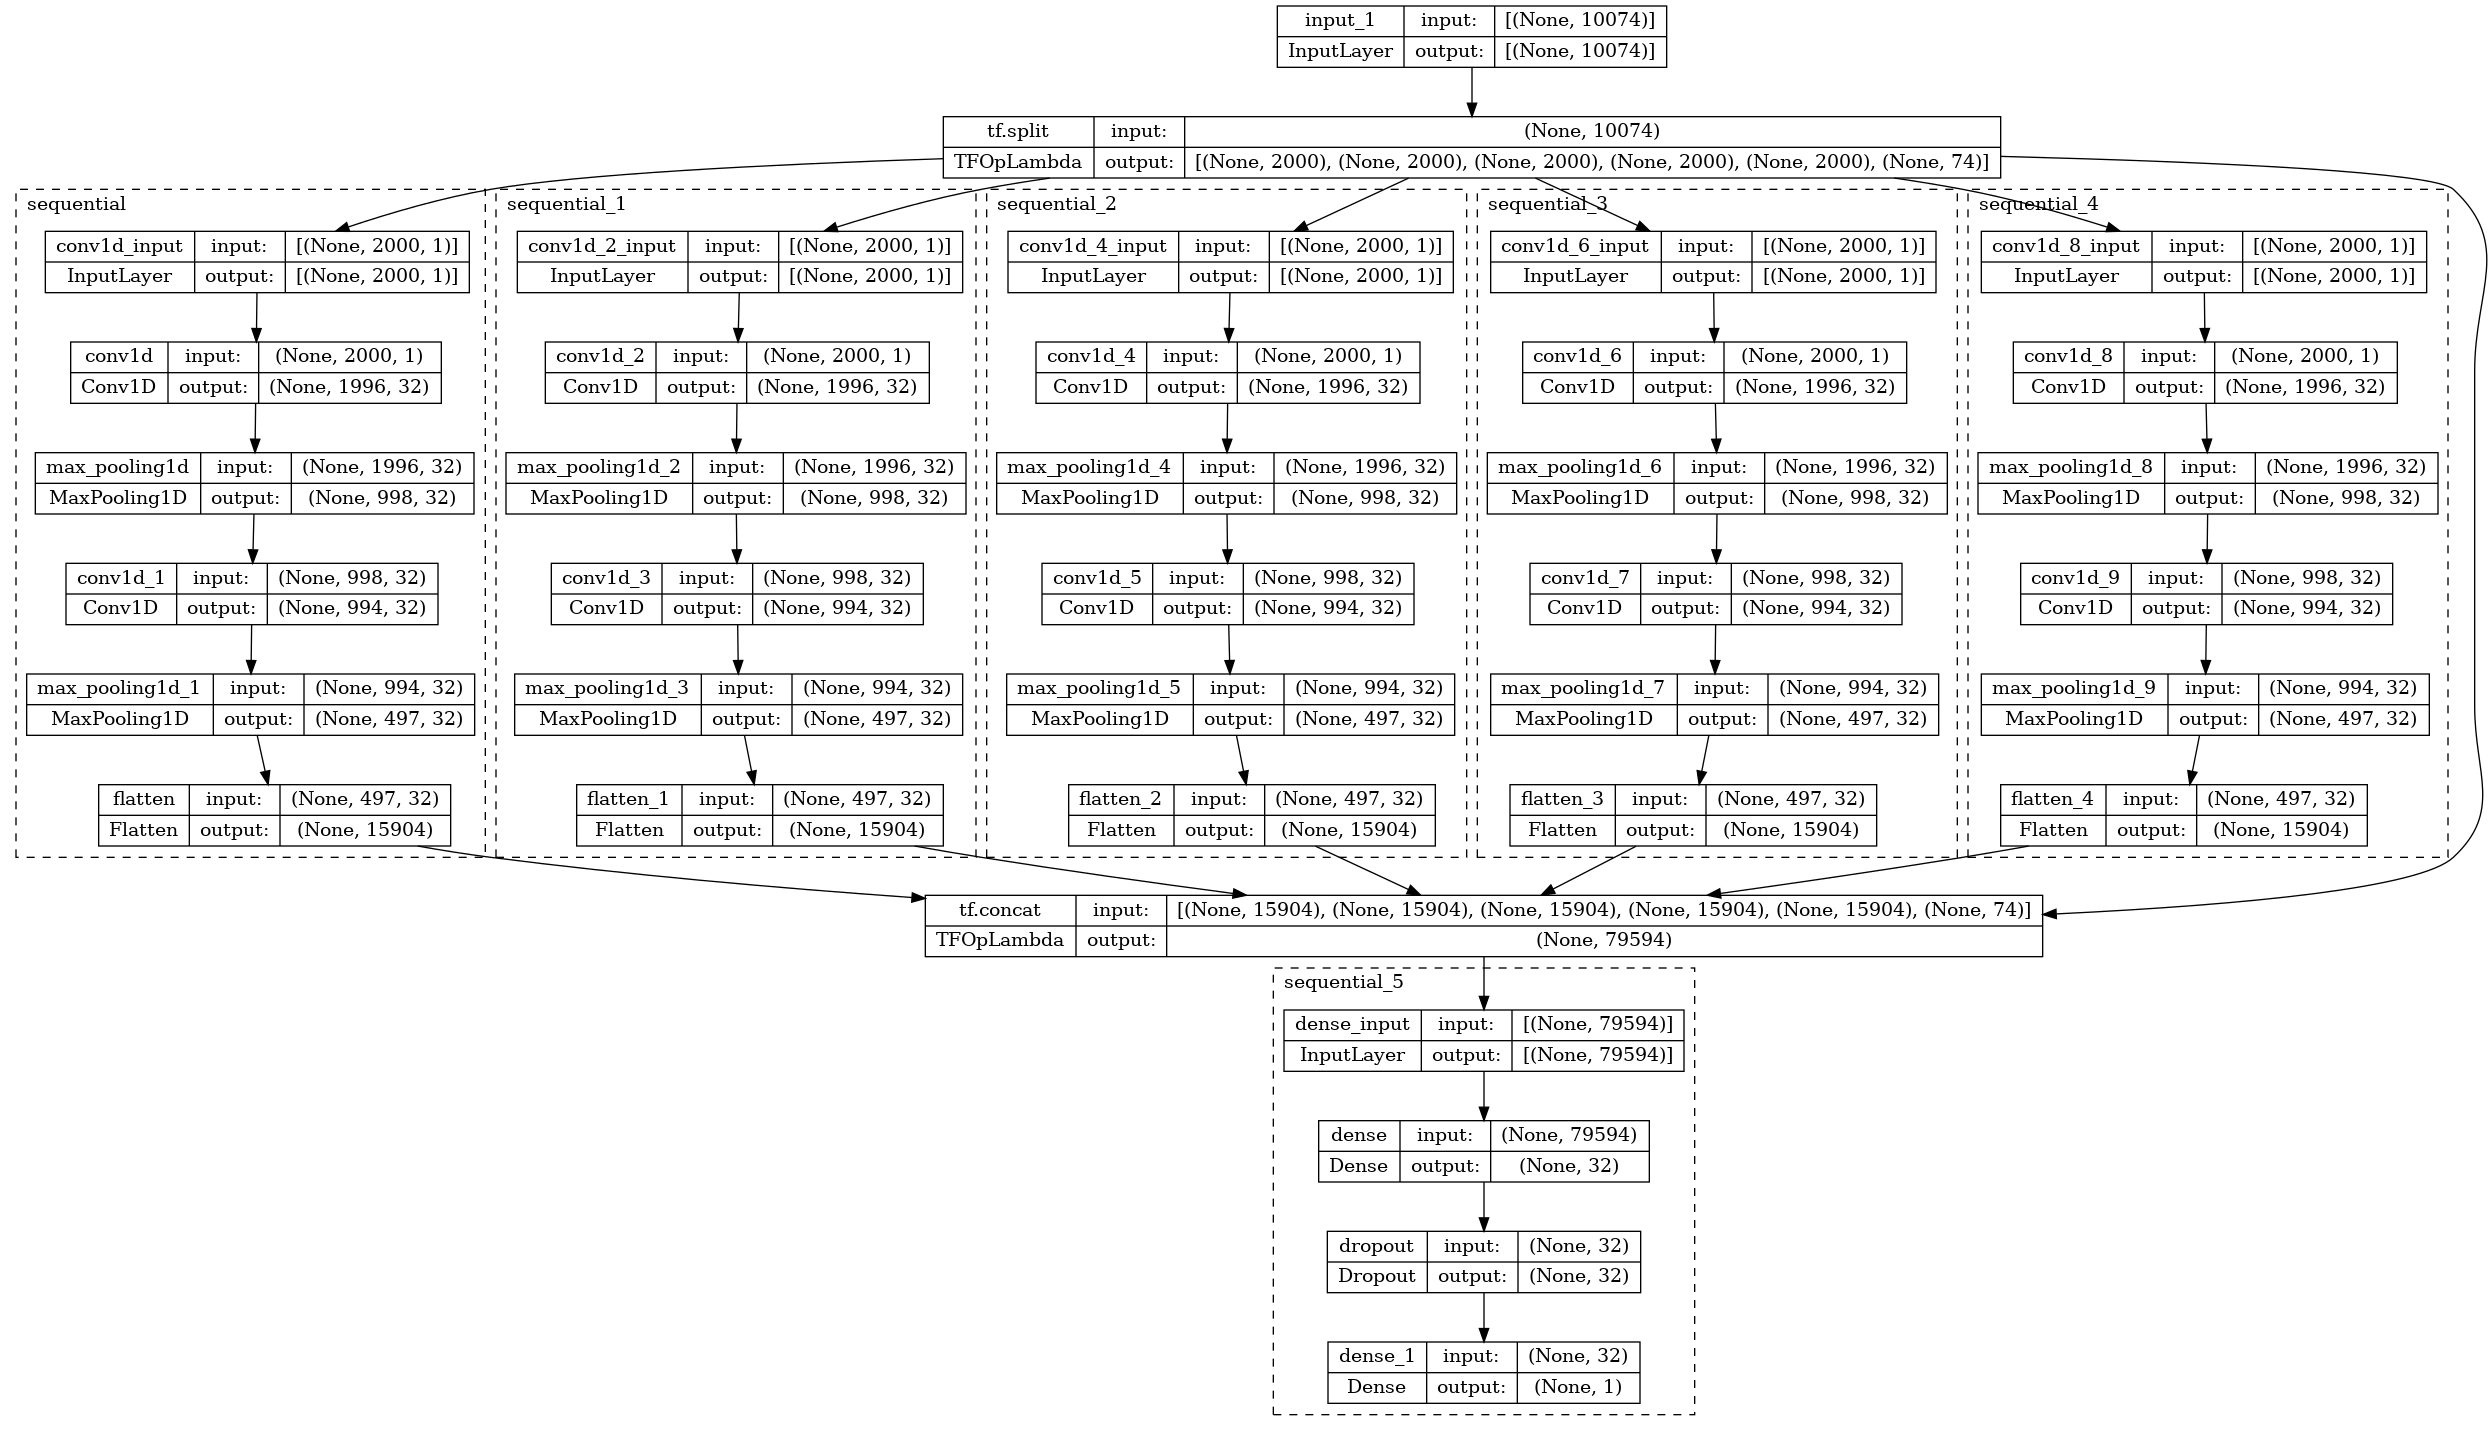

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def generate_CNN_backbone(samples_per_channel, filters=[32, 32], kernel_size=[5, 5], pool_size=[2, 2]):
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(filters[0], kernel_size=kernel_size[0], activation='relu', input_shape=(samples_per_channel, 1)))
    model.add(layers.MaxPooling1D(pool_size=pool_size[0]))
    model.add(layers.Conv1D(filters[1], kernel_size=kernel_size[1], activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=pool_size[1]))
    model.add(layers.Flatten())
    return model


input_layer = layers.InputLayer(input_shape=input_shape)

input_split = tf.split(
    input_layer.output, 
    [
        *[samples_per_channel for _ in range(channels)], 
        (len(train_seq.feature_names["segment_features"])
        +len(train_seq.feature_names["records_features"])
        +len(train_seq.feature_names["subject_features"]))
    ], 
    axis=1
)

cnn_backbones = [
    generate_CNN_backbone(samples_per_channel) for _ in range(channels)
]

head_input_1 = [
    cnn_backbone(cnn_backbone_input)
    for cnn_backbone, cnn_backbone_input in zip(cnn_backbones, input_split[:5])
]

head_input = tf.concat([*head_input_1, input_split[-1]], axis=1)

head = tf.keras.Sequential(
    [
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ]
)(head_input)

model = tf.keras.Model(inputs=input_layer.input, outputs=head)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

Epoch 1/100
15/15 [==============================] - 15s 842ms/step - loss: 0.9392 - accuracy: 0.6717 - val_loss: 0.6603 - val_accuracy: 0.7059
Epoch 2/100
15/15 [==============================] - 12s 787ms/step - loss: 0.5277 - accuracy: 0.8152 - val_loss: 0.6106 - val_accuracy: 0.7059
Epoch 3/100
15/15 [==============================] - 12s 800ms/step - loss: 0.5319 - accuracy: 0.8196 - val_loss: 0.5631 - val_accuracy: 0.7059
Epoch 4/100
15/15 [==============================] - 13s 898ms/step - loss: 0.4817 - accuracy: 0.8348 - val_loss: 0.5724 - val_accuracy: 0.7059
Epoch 5/100
15/15 [==============================] - 14s 899ms/step - loss: 0.4521 - accuracy: 0.8326 - val_loss: 0.5252 - val_accuracy: 0.7059
Epoch 6/100
15/15 [==============================] - 12s 816ms/step - loss: 0.4263 - accuracy: 0.8174 - val_loss: 0.5842 - val_accuracy: 0.7059
Epoch 7/100
15/15 [==============================] - 12s 810ms/step - loss: 0.4315 - accuracy: 0.8348 - val_loss: 0.5164 - val_accuracy:

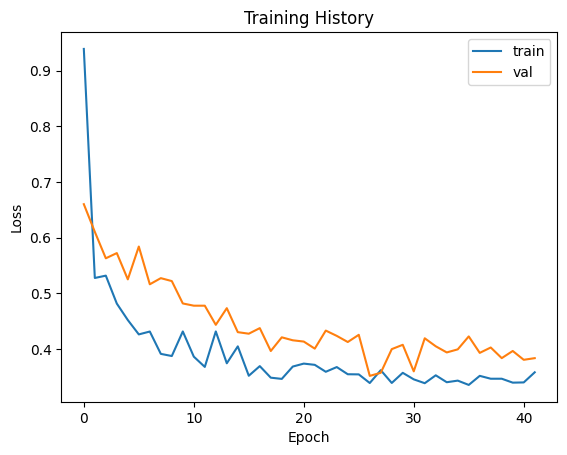

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(
    train_seq,
    epochs=100,
    validation_data=val_seq,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

plot_history(history)

In [ ]:
# 1. Segments Performance
print("====Segments Performance====")
print("Train:")
display(segment_performance(train_seq, model))
print("Val:")
display(segment_performance(val_seq, model))
print("Test:")
display(segment_performance(test_seq, model))

# 2. Pool Performance
print("====Pool Performance====")
print("Train:")
display(pool_performance(train_set, train_seq))
print("Val:")
display(pool_performance(val_set, val_seq))
print("Test:")
display(pool_performance(test_set, test_seq))

====Segments Performance====
Train:


,precision,recall,f1-score,f2 score,support
0,0.915301,0.893333,0.904184,0.897642,375.000000
1,0.574468,0.635294,0.603352,0.622120,85.000000
accuracy,0.845652,0.845652,0.845652,0.845652,0.845652
macro avg,0.744884,0.764314,0.753768,0.759881,460.000000
weighted avg,0.852321,0.845652,0.848595,0.846730,460.000000


Val:


,precision,recall,f1-score,f2 score,support
0,0.861111,0.861111,0.861111,0.861111,36.000000
1,0.666667,0.666667,0.666667,0.666667,15.000000
accuracy,0.803922,0.803922,0.803922,0.803922,0.803922
macro avg,0.763889,0.763889,0.763889,0.763889,51.000000
weighted avg,0.803922,0.803922,0.803922,0.803922,51.000000


Test:


,precision,recall,f1-score,f2 score,support
0,0.884058,0.924242,0.903704,0.915916,66.000000
1,0.761905,0.666667,0.711111,0.683761,24.000000
accuracy,0.855556,0.855556,0.855556,0.855556,0.855556
macro avg,0.822981,0.795455,0.807407,0.799838,90.000000
weighted avg,0.851484,0.855556,0.852346,0.854008,90.000000


====Pool Performance====
Train:


100%|█████████████████████████████████████████| 460/460 [01:46<00:00,  4.32it/s]


,precision,recall,f1-score,f2 score,support
0,0.945946,0.840000,0.889831,0.859247,375.000000
1,0.527559,0.788235,0.632075,0.717345,85.000000
accuracy,0.830435,0.830435,0.830435,0.830435,0.830435
macro avg,0.736753,0.814118,0.760953,0.788296,460.000000
weighted avg,0.868635,0.830435,0.842202,0.833026,460.000000


Val:


100%|███████████████████████████████████████████| 51/51 [00:11<00:00,  4.26it/s]


,precision,recall,f1-score,f2 score,support
0,0.958333,0.638889,0.766667,0.684524,36.00000
1,0.518519,0.933333,0.666667,0.804598,15.00000
accuracy,0.725490,0.725490,0.725490,0.725490,0.72549
macro avg,0.738426,0.786111,0.716667,0.744561,51.00000
weighted avg,0.828976,0.725490,0.737255,0.719840,51.00000


Test:


100%|███████████████████████████████████████████| 90/90 [00:20<00:00,  4.44it/s]


,precision,recall,f1-score,f2 score,support
0,0.950000,0.863636,0.904762,0.879630,66.000000
1,0.700000,0.875000,0.777778,0.833333,24.000000
accuracy,0.866667,0.866667,0.866667,0.866667,0.866667
macro avg,0.825000,0.869318,0.841270,0.856481,90.000000
weighted avg,0.883333,0.866667,0.870899,0.867284,90.000000


## B. Single Conv Backbone + Aggregated Features

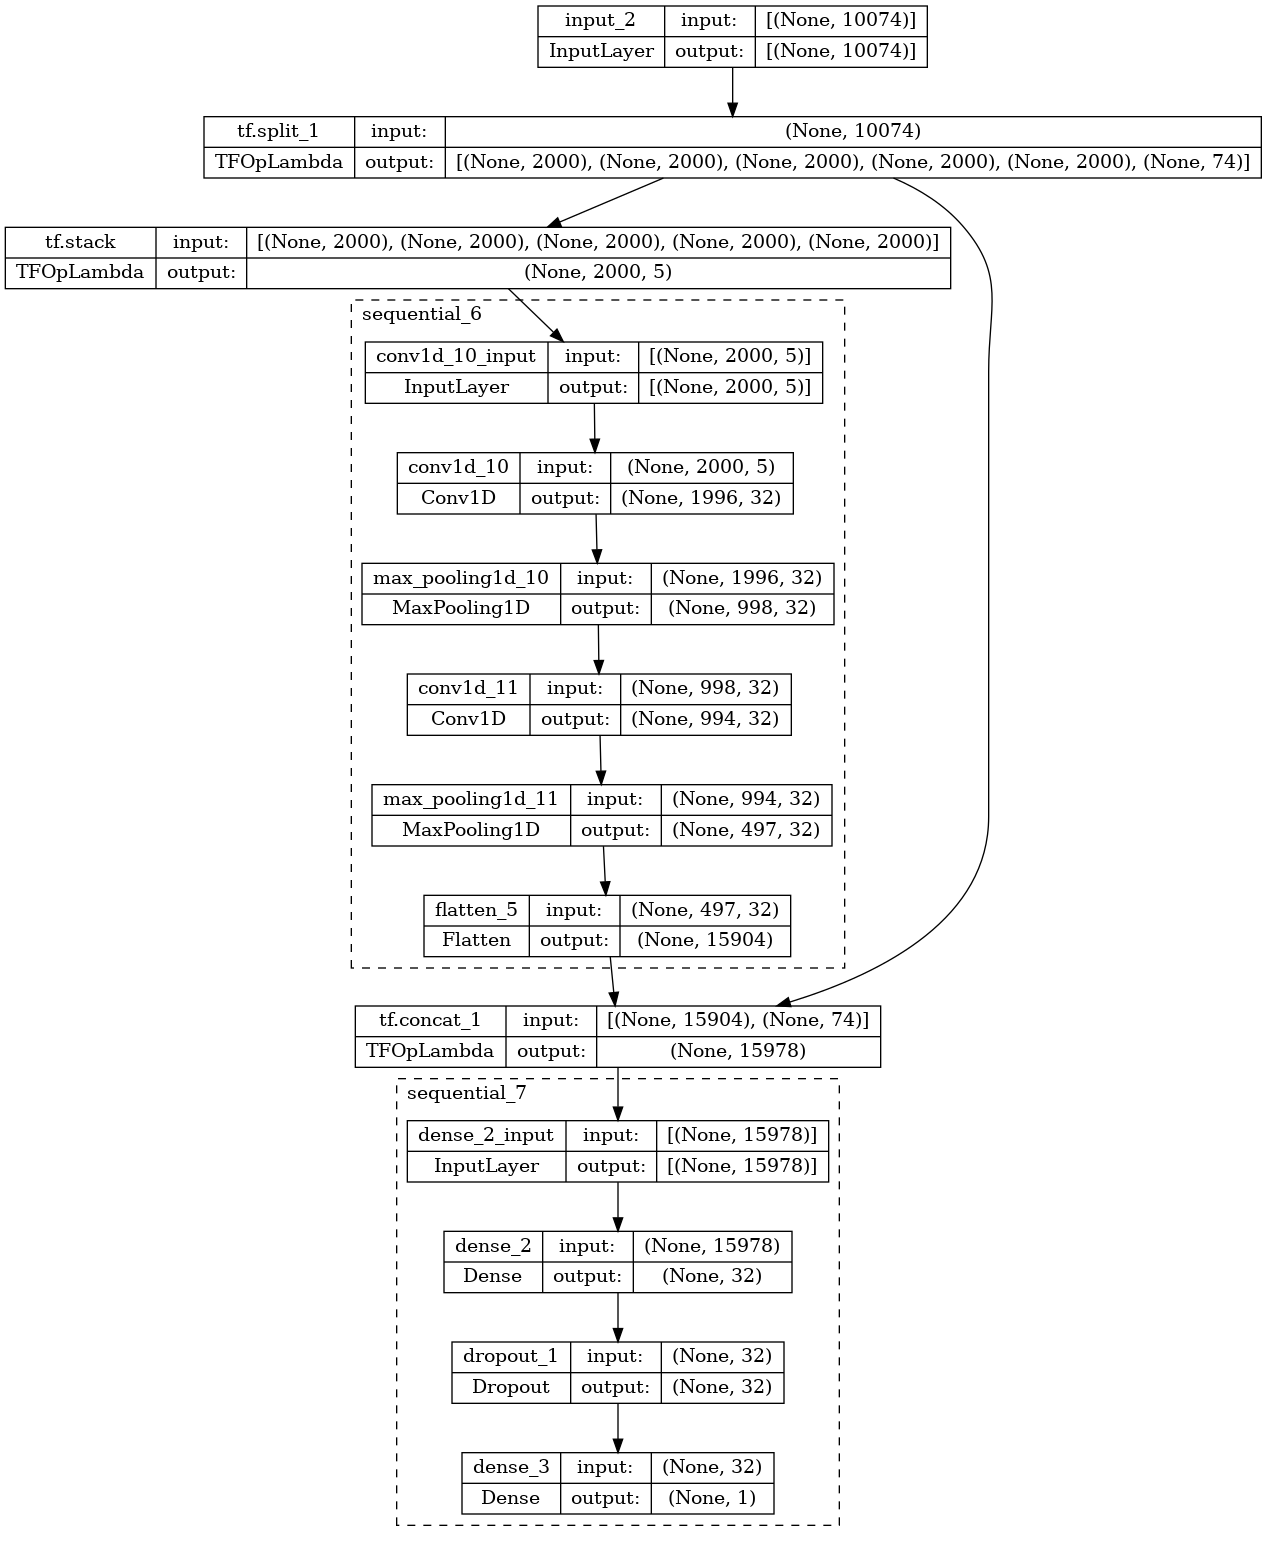

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def generate_CNN_backbone(samples_per_channel, channels, filters=[32, 32], kernel_size=[5, 5], pool_size=[2, 2]):
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(filters[0], kernel_size=kernel_size[0], activation='relu', input_shape=(samples_per_channel, channels)))
    model.add(layers.MaxPooling1D(pool_size=pool_size[0]))
    model.add(layers.Conv1D(filters[1], kernel_size=kernel_size[1], activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=pool_size[1]))
    model.add(layers.Flatten())
    return model


input_layer = layers.InputLayer(input_shape=input_shape)

input_split = tf.split(
    input_layer.output, 
    [
        *[samples_per_channel for _ in range(channels)], 
        (len(train_seq.feature_names["segment_features"])
        +len(train_seq.feature_names["records_features"])
        +len(train_seq.feature_names["subject_features"]))
    ], 
    axis=1
)

cnn_input = tf.stack(input_split[:5], axis=2)
cnn_backbone = generate_CNN_backbone(samples_per_channel, channels)
cnn_output = cnn_backbone(cnn_input)


head_input = tf.concat([cnn_output, input_split[-1]], axis=1)

head = tf.keras.Sequential(
    [
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ]
)(head_input)

model = tf.keras.Model(inputs=input_layer.input, outputs=head)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

Epoch 1/100
15/15 [==============================] - 12s 731ms/step - loss: 0.6080 - accuracy: 0.7391 - val_loss: 0.5952 - val_accuracy: 0.7059
Epoch 2/100
15/15 [==============================] - 10s 683ms/step - loss: 0.4791 - accuracy: 0.8217 - val_loss: 0.5923 - val_accuracy: 0.7059
Epoch 3/100
15/15 [==============================] - 10s 677ms/step - loss: 0.4778 - accuracy: 0.8022 - val_loss: 0.5656 - val_accuracy: 0.6863
Epoch 4/100
15/15 [==============================] - 10s 680ms/step - loss: 0.4397 - accuracy: 0.8217 - val_loss: 0.5775 - val_accuracy: 0.7059
Epoch 5/100
15/15 [==============================] - 10s 706ms/step - loss: 0.4501 - accuracy: 0.8065 - val_loss: 0.5026 - val_accuracy: 0.7255
Epoch 6/100
15/15 [==============================] - 12s 809ms/step - loss: 0.4158 - accuracy: 0.8348 - val_loss: 0.4986 - val_accuracy: 0.7451
Epoch 7/100
15/15 [==============================] - 12s 817ms/step - loss: 0.4302 - accuracy: 0.7935 - val_loss: 0.5399 - val_accuracy:

15/15 [==============================] - 10s 681ms/step - loss: 0.3283 - accuracy: 0.8609 - val_loss: 0.3860 - val_accuracy: 0.7647
Epoch 58/100
15/15 [==============================] - 10s 684ms/step - loss: 0.3367 - accuracy: 0.8522 - val_loss: 0.3945 - val_accuracy: 0.7843
Epoch 59/100
15/15 [==============================] - 10s 677ms/step - loss: 0.3450 - accuracy: 0.8152 - val_loss: 0.3824 - val_accuracy: 0.7451
Epoch 60/100
15/15 [==============================] - 10s 678ms/step - loss: 0.3262 - accuracy: 0.8522 - val_loss: 0.3675 - val_accuracy: 0.8039
Epoch 61/100
15/15 [==============================] - 10s 679ms/step - loss: 0.3308 - accuracy: 0.8478 - val_loss: 0.3873 - val_accuracy: 0.8039
Epoch 62/100
15/15 [==============================] - 10s 679ms/step - loss: 0.3317 - accuracy: 0.8391 - val_loss: 0.3675 - val_accuracy: 0.8235
Epoch 63/100
15/15 [==============================] - 10s 675ms/step - loss: 0.3222 - accuracy: 0.8674 - val_loss: 0.3366 - val_accuracy: 0.843

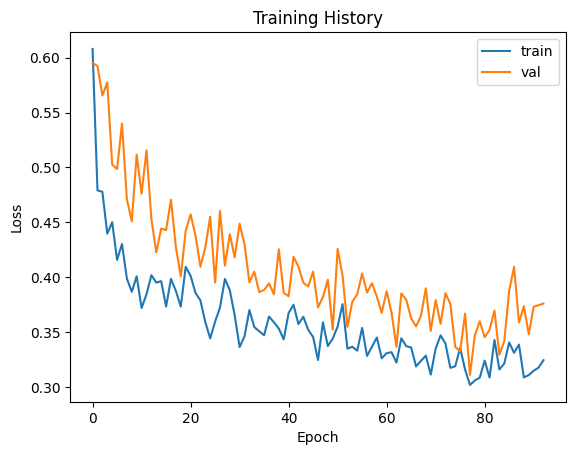

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# Train Model
history = model.fit(
    train_seq,
    epochs=100,
    validation_data=val_seq,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

plot_history(history)

In [ ]:
# 1. Segments Performance
print("====Segments Performance====")
print("Train:")
display(segment_performance(train_seq, model))
print("Val:")
display(segment_performance(val_seq, model))
print("Test:")
display(segment_performance(test_seq, model))

# 2. Pool Performance
print("====Pool Performance====")
print("Train:")
display(pool_performance(train_set, train_seq))
print("Val:")
display(pool_performance(val_set, val_seq))
print("Test:")
display(pool_performance(test_set, test_seq))

====Segments Performance====
Train:


,precision,recall,f1-score,f2 score,support
0,0.916010,0.930667,0.923280,0.927698,375.000000
1,0.670886,0.623529,0.646341,0.632458,85.000000
accuracy,0.873913,0.873913,0.873913,0.873913,0.873913
macro avg,0.793448,0.777098,0.784811,0.780078,460.000000
weighted avg,0.870716,0.873913,0.872107,0.873143,460.000000


Val:


,precision,recall,f1-score,f2 score,support
0,0.825000,0.916667,0.868421,0.896739,36.000000
1,0.727273,0.533333,0.615385,0.563380,15.000000
accuracy,0.803922,0.803922,0.803922,0.803922,0.803922
macro avg,0.776136,0.725000,0.741903,0.730060,51.000000
weighted avg,0.796257,0.803922,0.793999,0.798692,51.000000


Test:


,precision,recall,f1-score,f2 score,support
0,0.888889,0.969697,0.927536,0.952381,66.000000
1,0.888889,0.666667,0.761905,0.701754,24.000000
accuracy,0.888889,0.888889,0.888889,0.888889,0.888889
macro avg,0.888889,0.818182,0.844720,0.827068,90.000000
weighted avg,0.888889,0.888889,0.883368,0.885547,90.000000


====Pool Performance====
Train:


100%|█████████████████████████████████████████| 460/460 [01:38<00:00,  4.66it/s]


,precision,recall,f1-score,f2 score,support
0,0.944282,0.858667,0.899441,0.874525,375.000000
1,0.554622,0.776471,0.647059,0.718954,85.000000
accuracy,0.843478,0.843478,0.843478,0.843478,0.843478
macro avg,0.749452,0.817569,0.773250,0.796739,460.000000
weighted avg,0.872279,0.843478,0.852805,0.845778,460.000000


Val:


100%|███████████████████████████████████████████| 51/51 [00:10<00:00,  4.75it/s]


,precision,recall,f1-score,f2 score,support
0,1.000000,0.833333,0.909091,0.862069,36.000000
1,0.714286,1.000000,0.833333,0.925926,15.000000
accuracy,0.882353,0.882353,0.882353,0.882353,0.882353
macro avg,0.857143,0.916667,0.871212,0.893997,51.000000
weighted avg,0.915966,0.882353,0.886809,0.880850,51.000000


Test:


100%|███████████████████████████████████████████| 90/90 [00:18<00:00,  4.80it/s]


,precision,recall,f1-score,f2 score,support
0,0.953125,0.924242,0.938462,0.929878,66.000000
1,0.807692,0.875000,0.840000,0.860656,24.000000
accuracy,0.911111,0.911111,0.911111,0.911111,0.911111
macro avg,0.880409,0.899621,0.889231,0.895267,90.000000
weighted avg,0.914343,0.911111,0.912205,0.911419,90.000000


## C. Non Signal Features in model

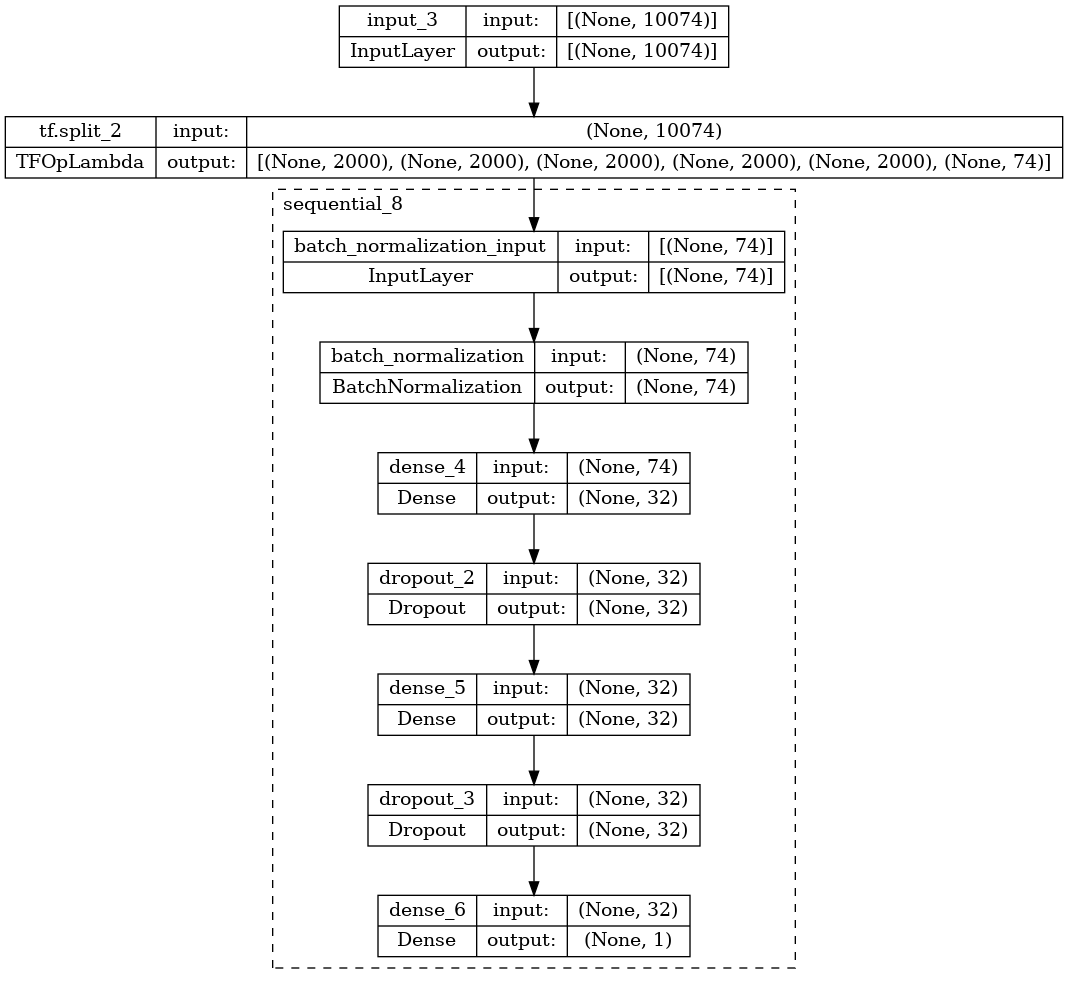

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

input_layer = layers.InputLayer(input_shape=input_shape)

input_split = tf.split(
    input_layer.output, 
    [
        *[samples_per_channel for _ in range(channels)], 
        (len(train_seq.feature_names["segment_features"])
        +len(train_seq.feature_names["records_features"])
        +len(train_seq.feature_names["subject_features"]))
    ], 
    axis=1
)


head_input = input_split[-1]

head = tf.keras.Sequential(
    [
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ]
)(head_input)

model = tf.keras.Model(inputs=input_layer.input, outputs=head)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

Epoch 1/100
15/15 [==============================] - 11s 673ms/step - loss: 0.6658 - accuracy: 0.6022 - val_loss: 0.8563 - val_accuracy: 0.3922
Epoch 2/100
15/15 [==============================] - 9s 631ms/step - loss: 0.5946 - accuracy: 0.7174 - val_loss: 0.7411 - val_accuracy: 0.5490
Epoch 3/100
15/15 [==============================] - 9s 621ms/step - loss: 0.5481 - accuracy: 0.7674 - val_loss: 0.6600 - val_accuracy: 0.7059
Epoch 4/100
15/15 [==============================] - 9s 624ms/step - loss: 0.5007 - accuracy: 0.7891 - val_loss: 0.5994 - val_accuracy: 0.7059
Epoch 5/100
15/15 [==============================] - 9s 631ms/step - loss: 0.4990 - accuracy: 0.8109 - val_loss: 0.5411 - val_accuracy: 0.7059
Epoch 6/100
15/15 [==============================] - 10s 648ms/step - loss: 0.4735 - accuracy: 0.8087 - val_loss: 0.4952 - val_accuracy: 0.6863
Epoch 7/100
15/15 [==============================] - 9s 622ms/step - loss: 0.4690 - accuracy: 0.8109 - val_loss: 0.4575 - val_accuracy: 0.70

Epoch 58/100
15/15 [==============================] - 9s 619ms/step - loss: 0.3237 - accuracy: 0.8630 - val_loss: 0.2915 - val_accuracy: 0.8824


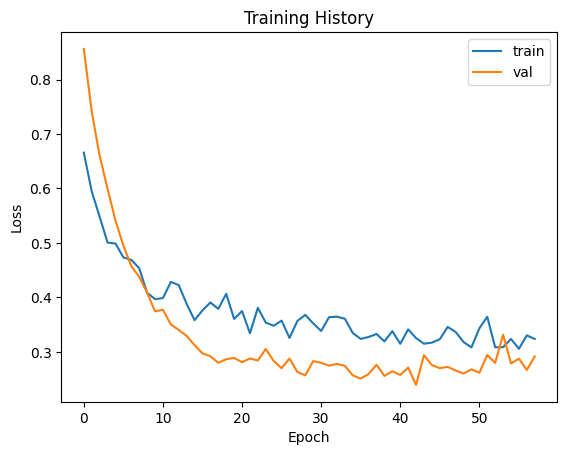

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# Train Model
history = model.fit(
    train_seq,
    epochs=100,
    validation_data=val_seq,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

plot_history(history)

In [ ]:
# 1. Segments Performance
print("====Segments Performance====")
print("Train:")
display(segment_performance(train_seq, model))
print("Val:")
display(segment_performance(val_seq, model))
print("Test:")
display(segment_performance(test_seq, model))

# 2. Pool Performance
print("====Pool Performance====")
print("Train:")
display(pool_performance(train_set, train_seq))
print("Val:")
display(pool_performance(val_set, val_seq))
print("Test:")
display(pool_performance(test_set, test_seq))

====Segments Performance====
Train:


,precision,recall,f1-score,f2 score,support
0,0.913386,0.928000,0.920635,0.925040,375.000000
1,0.658228,0.611765,0.634146,0.620525,85.000000
accuracy,0.869565,0.869565,0.869565,0.869565,0.869565
macro avg,0.785807,0.769882,0.777391,0.772782,460.000000
weighted avg,0.866237,0.869565,0.867697,0.868771,460.000000


Val:


,precision,recall,f1-score,f2 score,support
0,0.833333,0.972222,0.897436,0.940860,36.000000
1,0.888889,0.533333,0.666667,0.579710,15.000000
accuracy,0.843137,0.843137,0.843137,0.843137,0.843137
macro avg,0.861111,0.752778,0.782051,0.760285,51.000000
weighted avg,0.849673,0.843137,0.829563,0.834640,51.000000


Test:


,precision,recall,f1-score,f2 score,support
0,0.853333,0.969697,0.907801,0.943953,66.000000
1,0.866667,0.541667,0.666667,0.585586,24.000000
accuracy,0.855556,0.855556,0.855556,0.855556,0.855556
macro avg,0.860000,0.755682,0.787234,0.764769,90.000000
weighted avg,0.856889,0.855556,0.843499,0.848388,90.000000


====Pool Performance====
Train:


100%|█████████████████████████████████████████| 460/460 [01:33<00:00,  4.94it/s]


,precision,recall,f1-score,f2 score,support
0,0.950147,0.864000,0.905028,0.879957,375.000000
1,0.571429,0.800000,0.666667,0.740741,85.000000
accuracy,0.852174,0.852174,0.852174,0.852174,0.852174
macro avg,0.760788,0.832000,0.785847,0.810349,460.000000
weighted avg,0.880166,0.852174,0.860983,0.854232,460.000000


Val:


100%|███████████████████████████████████████████| 51/51 [00:09<00:00,  5.20it/s]


,precision,recall,f1-score,f2 score,support
0,0.967742,0.833333,0.895522,0.857143,36.000000
1,0.700000,0.933333,0.800000,0.875000,15.000000
accuracy,0.862745,0.862745,0.862745,0.862745,0.862745
macro avg,0.833871,0.883333,0.847761,0.866071,51.000000
weighted avg,0.888994,0.862745,0.867428,0.862395,51.000000


Test:


100%|███████████████████████████████████████████| 90/90 [00:19<00:00,  4.69it/s]


,precision,recall,f1-score,f2 score,support
0,0.923077,0.909091,0.916031,0.911854,66.000000
1,0.760000,0.791667,0.775510,0.785124,24.000000
accuracy,0.877778,0.877778,0.877778,0.877778,0.877778
macro avg,0.841538,0.850379,0.845770,0.848489,90.000000
weighted avg,0.879590,0.877778,0.878558,0.878059,90.000000


## D. Only Signal

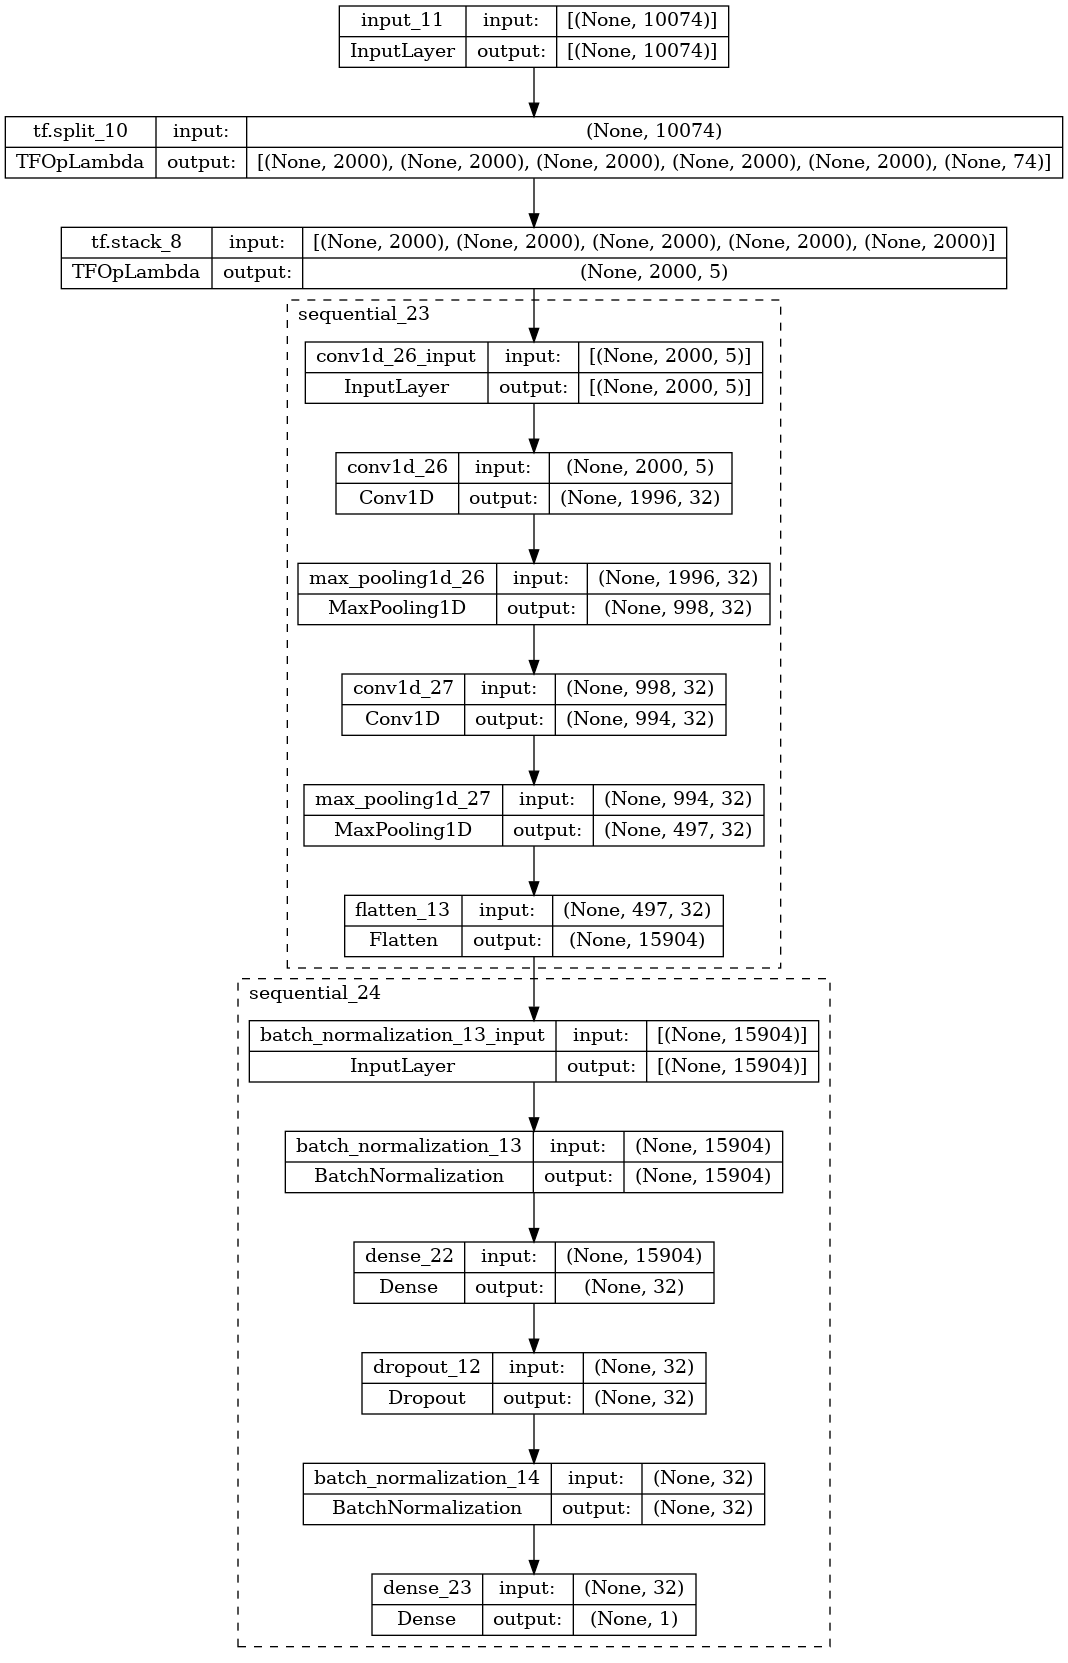

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

def generate_CNN_backbone(samples_per_channel, channels, filters=[32, 32], kernel_size=[5, 5], pool_size=[2, 2]):
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(filters[0], kernel_size=kernel_size[0], activation='relu', input_shape=(samples_per_channel, channels)))
    model.add(layers.MaxPooling1D(pool_size=pool_size[0]))
    model.add(layers.Conv1D(filters[1], kernel_size=kernel_size[1], activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=pool_size[1]))
    model.add(layers.Flatten())
    return model


input_layer = layers.InputLayer(input_shape=input_shape)

input_split = tf.split(
    input_layer.output, 
    [
        *[samples_per_channel for _ in range(channels)], 
        (len(train_seq.feature_names["segment_features"])
        +len(train_seq.feature_names["records_features"])
        +len(train_seq.feature_names["subject_features"]))
    ], 
    axis=1
)

cnn_input = tf.stack(input_split[:5], axis=2)
cnn_backbone = generate_CNN_backbone(samples_per_channel, channels)
cnn_output = cnn_backbone(cnn_input)
head = tf.keras.Sequential(
    [
        layers.BatchNormalization(),
        layers.Dense(
            32, activation='relu',
            kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.L2(1e-4),
            #activity_regularizer=regularizers.L2(1e-5)
        ),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ]
)(cnn_output)

model = tf.keras.Model(inputs=input_layer.input, outputs=head)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

Epoch 1/100
15/15 [==============================] - 13s 804ms/step - loss: 0.8614 - accuracy: 0.5109 - val_loss: 0.7359 - val_accuracy: 0.5686
Epoch 2/100
15/15 [==============================] - 10s 684ms/step - loss: 0.7092 - accuracy: 0.5978 - val_loss: 0.7389 - val_accuracy: 0.5490
Epoch 3/100
15/15 [==============================] - 10s 689ms/step - loss: 0.6855 - accuracy: 0.6478 - val_loss: 0.7433 - val_accuracy: 0.5686
Epoch 4/100
15/15 [==============================] - 10s 691ms/step - loss: 0.6621 - accuracy: 0.6283 - val_loss: 0.7167 - val_accuracy: 0.7059
Epoch 5/100
15/15 [==============================] - 10s 712ms/step - loss: 0.6172 - accuracy: 0.7043 - val_loss: 0.7239 - val_accuracy: 0.6667
Epoch 6/100
15/15 [==============================] - 10s 687ms/step - loss: 0.6541 - accuracy: 0.6826 - val_loss: 0.7303 - val_accuracy: 0.6078
Epoch 7/100
15/15 [==============================] - 10s 698ms/step - loss: 0.5930 - accuracy: 0.7152 - val_loss: 0.6933 - val_accuracy:

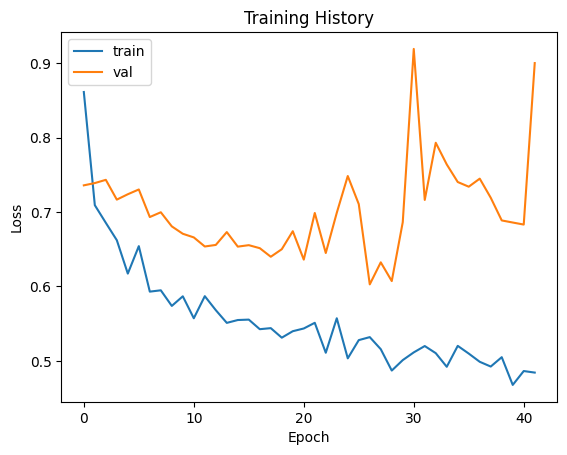

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# Train Model
history = model.fit(
    train_seq,
    epochs=100,
    validation_data=val_seq,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

plot_history(history)

In [ ]:
# 1. Segments Performance
print("====Segments Performance====")
print("Train:")
display(segment_performance(train_seq, model))
print("Val:")
display(segment_performance(val_seq, model))
print("Test:")
display(segment_performance(test_seq, model))

# 2. Pool Performance
print("====Pool Performance====")
print("Train:")
display(pool_performance(train_set, train_seq))
print("Val:")
display(pool_performance(val_set, val_seq))
print("Test:")
display(pool_performance(test_set, test_seq))

====Segments Performance====
Train:


,precision,recall,f1-score,f2 score,support
0,0.901316,0.730667,0.807069,0.759424,375.000000
1,0.352564,0.647059,0.456432,0.554435,85.000000
accuracy,0.715217,0.715217,0.715217,0.715217,0.715217
macro avg,0.626940,0.688863,0.631750,0.656929,460.000000
weighted avg,0.799916,0.715217,0.742277,0.721545,460.000000


Val:


,precision,recall,f1-score,f2 score,support
0,0.827586,0.666667,0.738462,0.693642,36.000000
1,0.454545,0.666667,0.540541,0.609756,15.000000
accuracy,0.666667,0.666667,0.666667,0.666667,0.666667
macro avg,0.641066,0.666667,0.639501,0.651699,51.000000
weighted avg,0.717868,0.666667,0.680249,0.668969,51.000000


Test:


,precision,recall,f1-score,f2 score,support
0,0.880000,0.666667,0.758621,0.700637,66.000000
1,0.450000,0.750000,0.562500,0.661765,24.000000
accuracy,0.688889,0.688889,0.688889,0.688889,0.688889
macro avg,0.665000,0.708333,0.660560,0.681201,90.000000
weighted avg,0.765333,0.688889,0.706322,0.690271,90.000000


====Pool Performance====
Train:


100%|█████████████████████████████████████████| 460/460 [01:41<00:00,  4.55it/s]


,precision,recall,f1-score,f2 score,support
0,0.956757,0.472000,0.632143,0.525223,375.000000
1,0.280000,0.905882,0.427778,0.626016,85.000000
accuracy,0.552174,0.552174,0.552174,0.552174,0.552174
macro avg,0.618378,0.688941,0.529960,0.575619,460.000000
weighted avg,0.831704,0.552174,0.594380,0.543847,460.000000


Val:


100%|███████████████████████████████████████████| 51/51 [00:10<00:00,  4.86it/s]


,precision,recall,f1-score,f2 score,support
0,0.882353,0.416667,0.566038,0.465839,36.00000
1,0.382353,0.866667,0.530612,0.691489,15.00000
accuracy,0.549020,0.549020,0.549020,0.549020,0.54902
macro avg,0.632353,0.641667,0.548325,0.578664,51.00000
weighted avg,0.735294,0.549020,0.555618,0.532206,51.00000


Test:


100%|███████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


,precision,recall,f1-score,f2 score,support
0,0.909091,0.151515,0.259740,0.181818,66.000000
1,0.291139,0.958333,0.446602,0.657143,24.000000
accuracy,0.366667,0.366667,0.366667,0.366667,0.366667
macro avg,0.600115,0.554924,0.353171,0.419481,90.000000
weighted avg,0.744304,0.366667,0.309570,0.308571,90.000000


# Training TabNet

In [ ]:
from itertools import product

def build_data_from_seq(data_seq, repeat=1):
    """Returns collects X, y after iterating over a Sequence object
    """
    X_, y_ = [], []
    for i, (X, y) in product(range(repeat), data_seq):
        X_.append(X)
        y_.append(y)
    X_ = np.concatenate(X_)
    y_ = np.concatenate(y_)
    return X_, y_

In [ ]:
X_train, y_train = build_data_from_seq(train_seq, repeat=3)
X_val, y_val = build_data_from_seq(val_seq, repeat=3)
X_test, y_test = build_data_from_seq(test_seq, repeat=3)

In [ ]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# Model definition
tabnet_model = TabNetClassifier(
    n_d=64,
    n_a=64,
    n_steps=5,
    gamma=1.3,
    n_independent=2,
    n_shared=2,
    cat_idxs=[],
    cat_dims=[],
    cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    scheduler_params={"step_size": 50, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax",
    device_name="auto"
)

/home/juan/Desktop/heart_failure/HeartKinetics/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning:

Device used : cpu



In [ ]:
# Calculate class weights
from sklearn.utils import class_weight
class_weights_ = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
class_weights_ = torch.tensor(class_weights_, dtype=torch.float32)

# Model Training
tabnet_model.fit(
    X_train,
    y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=["train", "val"],
    eval_metric=["accuracy"],
    max_epochs=200,
    patience=50,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    weights=class_weights_,
    drop_last=False
)


epoch 0  | loss: 1.66718 | train_accuracy: 0.81522 | val_accuracy: 0.70588 |  0:00:13s
epoch 1  | loss: 1.23475 | train_accuracy: 0.81739 | val_accuracy: 0.70588 |  0:00:27s
epoch 2  | loss: 1.04738 | train_accuracy: 0.81522 | val_accuracy: 0.70588 |  0:00:41s
epoch 3  | loss: 1.01199 | train_accuracy: 0.81522 | val_accuracy: 0.70588 |  0:00:54s
epoch 4  | loss: 0.89983 | train_accuracy: 0.81522 | val_accuracy: 0.70588 |  0:01:08s
epoch 5  | loss: 0.81348 | train_accuracy: 0.81522 | val_accuracy: 0.70588 |  0:01:22s
epoch 6  | loss: 0.77271 | train_accuracy: 0.81522 | val_accuracy: 0.70588 |  0:01:35s
epoch 7  | loss: 0.7001  | train_accuracy: 0.81522 | val_accuracy: 0.70588 |  0:01:49s
epoch 8  | loss: 0.68285 | train_accuracy: 0.81522 | val_accuracy: 0.70588 |  0:02:05s


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report

y_pred_train = tabnet_model.predict(X_train)
report_train = classification_report(y_train, y_pred_train)

y_pred_val = tabnet_model.predict(X_val)
report_val = classification_report(y_val, y_pred_val)

y_pred_test = tabnet_model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)

print(f"{' '*8}{'='*10} Train set scores {'='*10}")
print(report_train)

print(f"{' '*8}{'='*10} Val set scores {'='*10}")
print(report_val)

print(f"{' '*8}{'='*10} Test set scores {'='*10}")
print(report_test)

In [ ]:
import shap
explainer = shap.Explainer(tabnet_model.predict, X_val)
shap_values = explainer(X_val[:30,:])
shap.summary_plot(
    shap_values.values, X_val, plot_type='bar', feature_names=train_seq.feature_names, max_display=10
)

In [ ]:
fs = 200

In [ ]:
from datetime import timedelta
from task_2_signal_preprocessing.autocorrelation_segment_checker import check_segment

def get_valid_segment(signal, segment_duration, threshold, plot=False, max_tries=60, annotation=None):
    signal = signal.dropna()
    signal_duration = max(signal.index).total_seconds()
    max_start = signal_duration - segment_duration

    is_valid_segment = False
    tries = 0
    while not is_valid_segment and tries < max_tries:
        start_timedelta = timedelta(seconds=np.random.random() * max_start)
        segment = signal[start_timedelta: start_timedelta + timedelta(seconds=segment_duration)]
        is_valid_segment = check_segment(segment, fs, threshold, plot, annotation)
        tries += 1
        
    base_len = int(fs*segment_duration)
    if segment.shape[0] > base_len:
        segment = segment.values[:base_len]
    else:
        segment = np.pad(segment.values, (0, base_len - segment.shape[0]), mode='constant')
        
    #print(segment.shape, annotation)
    if is_valid_segment:
        return segment
    else:
        # If cannot find a valid segment after max_tries, it will return the last sampled segment
        return segment 